# Replace Synchronous Generators

This demo shows how to replace synchronous generators with renewable generators.

In [1]:
import andes

If matplotlib inline plots are not showing, use the following line magic to enable it.

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=20)

When loading the case file, don't set it up because adding new devices is not allowed after `System.setup()`.

In [4]:
ss = andes.load(andes.get_case('ieee14/ieee14_linetrip.xlsx'),
                setup=False, no_output=True, default_config=False)

Working directory: "/Users/jinningwang/work/andes/icebar/marginal"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 12 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.0963 seconds.
Parsing input file "/Users/jinningwang/work/andes/andes/cases/ieee14/ieee14_linetrip.xlsx"...
Input file parsed in 0.1880 seconds.


> **Note**: Starting from version 1.9.3, the `GroupBase` class includes the `as_dict` and `as_df` methods, which collect common parameters from all models in the group.

In [5]:
ss.StaticGen.as_df()

,u,name,idx,bus,Sn,Vn,p0,q0,ra,xs
0,1,2,2,2,100,69,0.40000,0.15000,0,0.13
1,1,3,3,3,100,69,0.40000,0.15000,0,0.13
2,1,4,4,6,100,138,0.30000,0.10000,0,0.12
3,1,5,5,8,100,69,0.35000,0.10000,0,0.12
4,1,1,1,1,100,69,0.81442,0.01962,0,0.23


In [6]:
ss.SynGen.as_df()

,u,name,idx,bus,gen,Sn,Vn,fn,M,D
0,1,GENROU_1,GENROU_1,1,1,100,69,60,8,0
1,1,GENROU_2,GENROU_2,2,2,100,69,60,13,0
2,1,GENROU_3,GENROU_3,3,3,100,69,60,10,0
3,1,GENROU_4,GENROU_4,6,4,100,138,60,10,0
4,1,GENROU_5,GENROU_5,8,5,100,69,60,10,0


We can see that in this case, the synchronous generators are connected to static generators in a one-to-one relationship.

To achieve a renewable penetrated system, we need to replace a synchronous generator with a renewable generator.
It can be done in steps:
1. Add a renewable generator
2. Turn off the replaced synchronous generator

In [7]:
ss.add(model='REGCV2', param_dict=dict(bus=1, gen=1, Sn=100, Kpvd=0.1, Kivd=0.01, Kpvq=0.1, Kivq=0.01))

'REGCV2_1'

In [8]:
ss.REGCV2.as_df()

,idx,u,name,bus,gen,coi2,Sn,fn,Tc,kw,...,ra,xs,gammap,gammaq,Kpvd,Kivd,Kpvq,Kivq,Tiq,Tid
uid,,,,,,,,,,,,,,,,,,,,,
0,REGCV2_1,1,REGCV2_1,1,1,None,100,60.0,0.01,0.0,...,0.0,0.2,1.0,1.0,0.1,0.01,0.1,0.01,0.01,0.01


> **Note**: Starting from version 1.9.3, the `GroupBase` class includes the `alter` method.

In [9]:
ss.SynGen.alter(src='u', idx='GENROU_1', value=0)

True

In [10]:
ss.setup()

System internal structure set up in 0.0163 seconds.


True

In [11]:
ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0036 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.964193111e-12
Converged in 4 iterations in 0.0162 seconds.


True

Here we manually tune two parameters to fix the TDS initialization:
1. Extend `TGOV1.VMIN` to a low value to alleviate the limiter `TGOV1.LAG_LIM`
2. Turn off the stability criteria check by setting `TDS.criteria = 0`

In [12]:
ss.TGOV1.alter(src='VMIN', idx=ss.TGOV1.idx.v, value=-10)
ss.TDS.config.criteria = 0

In [13]:
_ = ss.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_1 | 0      | 1    


Initialization for dynamics completed in 0.0212 seconds.
Initialization was successful.


In [14]:
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-20.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggler_1>: Line.Line_1 status changed to 0 at t=1.0 sec.
<Toggle Toggler_2>: Line.Line_1 status changed to 1 at t=1.1 sec.


Simulation to t=20.00 sec completed in 0.8902 seconds.


True

Then we can see that now the replaced synchronous generator `GENROU_5` is replaced by a renewable generator `REGCV2_1`.

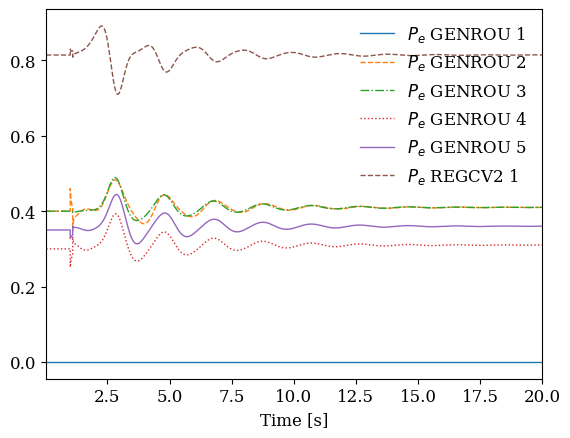

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [15]:
ss.TDS.plt.plot([ss.GENROU.Pe, ss.REGCV2.Pe])

Now let's inspect the excitation system.

In [16]:
ss.Exciter.models

OrderedDict([('EXDC2', EXDC2 (0 devices) at 0x130c5d120),
             ('IEEEX1', IEEEX1 (0 devices) at 0x130c5e5c0),
             ('ESDC1A', ESDC1A (0 devices) at 0x130c5f8e0),
             ('ESDC2A', ESDC2A (0 devices) at 0x130c95330),
             ('EXST1', EXST1 (1 device) at 0x130c96a70),
             ('ESST3A', ESST3A (4 devices) at 0x130c97ca0),
             ('SEXS', SEXS (0 devices) at 0x130cc9c60),
             ('IEEET1', IEEET1 (0 devices) at 0x130cca950),
             ('EXAC1', EXAC1 (0 devices) at 0x130ccbdc0),
             ('EXAC2', EXAC2 (0 devices) at 0x130cf9420),
             ('EXAC4', EXAC4 (0 devices) at 0x130cfb1f0),
             ('ESST4B', ESST4B (0 devices) at 0x130d2c1c0),
             ('AC8B', AC8B (0 devices) at 0x130d2dff0),
             ('IEEET3', IEEET3 (0 devices) at 0x130d2fa00),
             ('ESAC1A', ESAC1A (0 devices) at 0x130d5cdc0),
             ('ESST1A', ESST1A (0 devices) at 0x130d5ea10),
             ('ESAC5A', ESAC5A (0 devices) at 0x130d90e80)]

We can see that the excitation voltage for `GENROU_1` is also turned off as expected.

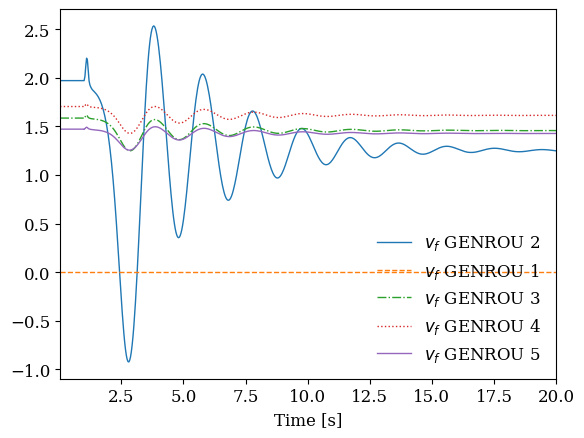

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [17]:
ss.TDS.plt.plot([ss.EXST1.vf, ss.ESST3A.vf])